### Imports and function definitions

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
import pandas as pd

from IPython import display

tensorflow version:  2.4.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2
GPUs:  2


### Ways to iterate over the dataset

### Load and Prepare the Dataset / Preprocessing Functions

In [3]:
# From https://www.tensorflow.org/datasets/keras_example

(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'celeb_a',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def preprocess(data):
    """Normalizes images: `uint8` -> `float32`."""
    image = data['image']
    label = data['attributes']
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

ds_train = ds_train_raw.map(
    preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
ds_train

<PrefetchDataset shapes: ((None, 28, 28, 3), {5_o_Clock_Shadow: (None,), Arched_Eyebrows: (None,), Attractive: (None,), Bags_Under_Eyes: (None,), Bald: (None,), Bangs: (None,), Big_Lips: (None,), Big_Nose: (None,), Black_Hair: (None,), Blond_Hair: (None,), Blurry: (None,), Brown_Hair: (None,), Bushy_Eyebrows: (None,), Chubby: (None,), Double_Chin: (None,), Eyeglasses: (None,), Goatee: (None,), Gray_Hair: (None,), Heavy_Makeup: (None,), High_Cheekbones: (None,), Male: (None,), Mouth_Slightly_Open: (None,), Mustache: (None,), Narrow_Eyes: (None,), No_Beard: (None,), Oval_Face: (None,), Pale_Skin: (None,), Pointy_Nose: (None,), Receding_Hairline: (None,), Rosy_Cheeks: (None,), Sideburns: (None,), Smiling: (None,), Straight_Hair: (None,), Wavy_Hair: (None,), Wearing_Earrings: (None,), Wearing_Hat: (None,), Wearing_Lipstick: (None,), Wearing_Necklace: (None,), Wearing_Necktie: (None,), Young: (None,)}), types: (tf.float32, {5_o_Clock_Shadow: tf.bool, Arched_Eyebrows: tf.bool, Attractive: tf

In [5]:
for images, attributes in ds_train:
    break
print(images.shape)
print(attributes.keys())

(128, 28, 28, 3)
dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])


In [6]:
images[0].shape

TensorShape([28, 28, 3])

In [7]:
images.numpy().max()

1.0

## Create the models

### Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [8]:
# Add attribute vectors
#attributes.items()

In [9]:
label = layers.Input(shape=(1,))
#label_embedding = layers.Flatten()(layers.Embedding(40, 100)(label))
label_embedding = layers.Embedding(40, 100)(label)
print(label_embedding)
n_nodes = 7 * 7
li = layers.Dense(n_nodes)(label_embedding)
print(li)
li = layers.Reshape((7,7,1))(li)
print(li)
noise = layers.Input(shape=(100,))
model_input = layers.multiply([noise, label_embedding])
print(model_input)
print(noise.shape)
print(label_embedding.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 100), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 49), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 100), dtype=tf.float32, name=None), name='multiply/mul:0', description="created by layer 'multiply'")
(None, 100)
(None, 1, 100)


In [10]:
#attributes.values()

In [11]:
# Create random values to be multiple with random attributes to form noise for generator input
noise_dim = 100
attribute_embeddings = tf.Variable(initial_value=tf.random.normal([40, noise_dim]), trainable=True) # Do this once only, but add to optimizers
print('p1: ',attribute_embeddings.shape)

def initiate_seed_weights(attributes, attribute_embeddings):
    # Convert to tensor
    #print(attributes.values().shape)
    #print('p2: ',attribute_embeddings.shape)
    batch_attributes_as_bool_tensor = tf.transpose(tf.stack(list(attributes.values())))
    #print(batch_attributes_as_bool_tensor.shape)
    # Convert from boolean to float
    batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
    #print(batch_attributes_as_float_tensor.shape)
    # Create projection of attributes into embedding space
    attribute_input = tf.matmul(batch_attributes_as_float_tensor, attribute_embeddings) 
    return attribute_input

attributes_random = np.random.choice(a=[False, True], size=(128,40)) # this doesn't seem to be used anywhere
attributes_noise = initiate_seed_weights(attributes, attribute_embeddings)
print(attributes_noise.shape)

p1:  (40, 100)
(128, 100)


In [12]:
# The generator
def make_generator_model():
    
    model = tf.keras.Sequential(name='Generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    
    # Output layer
    model.add(layers.Conv2D(3, (3,3), activation='sigmoid', padding = 'same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 3)

    return model

<dtype: 'float32'>
(1, 28, 28, 3)


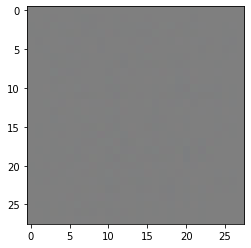

In [13]:
# Create an image using the untrained generator
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.dtype)
print(generated_image.shape)

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.imshow(generated_image[0])

None

<dtype: 'float32'>
(128, 28, 28, 3)


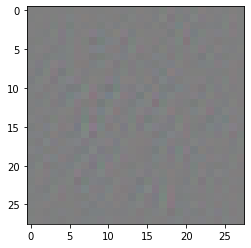

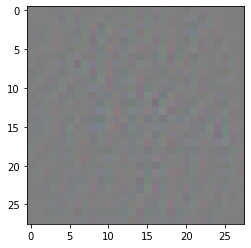

In [14]:
generator = make_generator_model()

generated_image = generator(attributes_noise, training=False)
print(generated_image.dtype)
print(generated_image.shape)

plt.imshow(generated_image[0])
plt.show()

plt.imshow(generated_image[1])
plt.show()

None

### Discriminator

The discriminator is a CNN-based image classifier.

In [15]:
noise = tf.random.normal([28, 28, 3])
noise.shape

TensorShape([28, 28, 3])

In [16]:
def make_discriminator_model():
    
    # label input
    input_label = layers.Input(shape=(100))
    input_image = layers.Input(shape=(28,28,3))
    #noise = tf.random.normal([28, 28, 3])

    #multi_image_model = tf.keras.Sequential(name='Discriminator_multi_image')
    #multi_image_model.add(layers.Conv3D(64, (5, 5, 5), padding='same'))
    
    
    conv_model = tf.keras.Sequential(name='Discriminator_conv_model')
    # downsample
    conv_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    conv_model.add(layers.LeakyReLU())
    conv_model.add(layers.Dropout(0.3))
    
    #downsample
    conv_model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    conv_model.add(layers.BatchNormalization())
    conv_model.add(layers.LeakyReLU())
    conv_model.add(layers.Dropout(0.3))
    
    # classifier
    conv_model.add(layers.Flatten())
    
    # Concatentate the new one here
    # The feed the concatenated model into the dense layer
    
    #multi_image_feature = multi_image_model(tf.expand_dims(input_image, axis=0))
    #multi_image_feature = tf.squeeze(multi_image_feature, axis=0)
    
    img_feature_vec = conv_model(input_image) #input_image+noise*10)
    
    # concat label as a channel
    merge = layers.Concatenate()([img_feature_vec, input_label])
    
    # multi-layer perceptrons
    mlp = tf.keras.Sequential(name='Discriminator_mlp')
    mlp.add(layers.Dense(128))
    mlp.add(layers.LeakyReLU())
    mlp.add(layers.Dropout(0.3))
    mlp.add(layers.Dense(1))
    
    output = mlp(merge)
    
    # Need to create new model here with correct shapes which need to be defined as inputs
    model = tf.keras.Model([input_image, input_label], output, name='Discriminator')

    return model

In [17]:
# Classify the generated images as real or fake using the discriminator.
# Model is trained to output positive values for real images and negative values for fake images
discriminator = make_discriminator_model()

#decision = discriminator((generated_image, attributes_noise))
#print(decision.shape)
#print(decision[:10])

## Define the loss and optimisers

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Quantifies how well the discriminator is able to distinguish real images from fakes.  

It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

Quantifies how well it was able to trick the discriminator.  

If the generator is performng well, the discriminator will classify the fake images as real (or 1). This function compares the discriminators decisions on the generated images to an array of 1s

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimisers

Two different optimisers required since the two networks are trained separately

In [21]:
noise_dim = 100
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)
#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
attribute_embeddings = tf.Variable(initial_value=tf.random.normal([40, noise_dim]), trainable=True) # Do this once only, but add to optimizers

### Save checkpoints

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 attribute_embeddings=attribute_embeddings)

## Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [23]:
def initiate_seed_weights(attributes, attribute_embeddings):
    # Convert to tensor
    #print(attributes.values().shape)
    #print('p2: ',attribute_embeddings.shape)
    batch_attributes_as_bool_tensor = tf.transpose(tf.stack(list(attributes.values())))
    #print(batch_attributes_as_bool_tensor.shape)
    # Convert from boolean to float
    batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
    #print(batch_attributes_as_float_tensor.shape)
    # Create projection of attributes into embedding space
    attribute_input = tf.matmul(batch_attributes_as_float_tensor, attribute_embeddings) 
    return attribute_input

attributes_random = np.random.choice(a=[False, True], size=(128,40)) # this doesn't seem to be used anywhere
attributes_noise = initiate_seed_weights(attributes, attribute_embeddings)

In [24]:
@tf.function
def train_step(images, attributes):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        attribute_input = initiate_seed_weights(attributes, attribute_embeddings)

        generated_images = generator(attribute_input, training=True)
        real_output = discriminator((images, attribute_input), training=True)
        fake_output = discriminator((generated_images, attribute_input), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)# + [attribute_embeddings])
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables + [attribute_embeddings])

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))# + [attribute_embeddings]))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables + [attribute_embeddings]))
    
    return attribute_input
    
def train(dataset, epochs, num_examples_to_generate):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, attribute_batch in dataset:
            attribute_input = train_step(image_batch, attribute_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, attribute_input[:num_examples_to_generate])

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False. This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[i])
        plt.axis('off')

    image_folder = 'generated_images/'
    image_filepath = image_folder + 'image_at_epoch_{:04d}.png'
    plt.savefig(image_filepath.format(epoch))
    plt.show()


## Train the model

Generator and discriminator are trained simultaneously.  

It is important that the generator and discriminator do not overpower each other (i.e. they train at a similar rate)

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

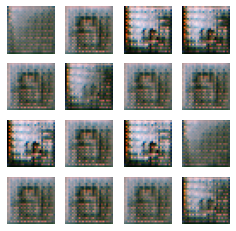

Time for epoch 5 is 40.25110936164856 sec


In [ ]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

train(ds_train, EPOCHS, num_examples_to_generate)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
test_array = np.full((40,),-1)
test_array[9] = 1 # blonde
test_array.shape

In [ ]:
# Try generating an image based on specific attributes
attributes_noise = initiate_seed_weights(attributes, attribute_embeddings)

generated_image = generator(attributes_noise, training=False)
print(generated_image.dtype)
print(generated_image.shape)

plt.imshow(generated_image[1])

None

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(50)

In [ ]:
attributes_random = np.random.choice(a=[False, True], size=(128,40))
attributes_random[1]

In [ ]:
generator.summary()

In [ ]:
weights = generator_optimizer.get_weights()
print(len(weights))
weights[1].shape